In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import dlib
from sklearn.preprocessing import normalize
from core.rejection_stem import simulate, Channel
from utils.plot import *
from utils.helper import *
#from scipy.stats import lognorm, expon, gengamma

%load_ext autoreload
%autoreload 2

# Load data

In [2]:
count_df = load_data('./data')

# load e14 and r1 separately / currently not used
e14, r1 = load_data('./data', combined=False)

# Normalise

In [3]:
# L1 norm
count_df[['ESC', 'EPI', 'NPC']] = normalize(count_df[['ESC', 'EPI', 'NPC']], norm='l1')

# Convert to long format
count_long = count_df.melt(id_vars=['Time', 'Source'], value_vars=['ESC', 'EPI', 'NPC'], var_name='Cell type', value_name='Count')

# normalise separate dfs
e14[['ESC', 'EPI', 'NPC']] = normalize(e14[['ESC', 'EPI', 'NPC']], norm='l1')
r1[['ESC', 'EPI', 'NPC']] = normalize(r1[['ESC', 'EPI', 'NPC']], norm='l1')

# Plot stem cell data combined (R1, E14)

Text(0.5, 1.0, 'Stem cell differentiation - E14 & R1 lineages')

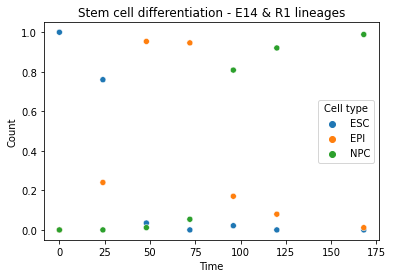

In [4]:
ax = sns.scatterplot(x="Time", y="Count",
                hue="Cell type", data=count_long)
ax.set_title('Stem cell differentiation - E14 & R1 lineages')

Text(0.5, 0.98, 'Stem cell differentiation - E14 & R1 lineages combined')

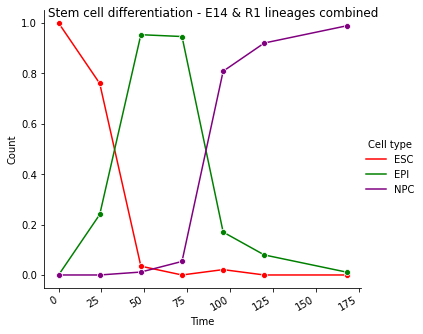

In [5]:
g = sns.relplot(x="Time", y="Count", kind="line", 
                hue='Cell type', palette=['red', 'green', 'purple'], 
                marker='o', data=count_long)
g.fig.autofmt_xdate()
g.fig.suptitle("Stem cell differentiation - E14 & R1 lineages combined")


# Load sampled data and calculate 95% CI

In [6]:
# load 10x sampled k-means labelings
# data are already L1 normalised
bs_raw = pd.read_csv('./data/bootstraps10.csv')

# Calculate sample averages - used for RMSE calculation during maxLIPO optimization
bs_avg = calculate_bs_avg(bs_raw)

# remove poor datapoint: e14 75 esc - only for maxLIPO, otherwise keep for plots
idx = bs_avg[(bs_avg.state=='ESC') & (bs_avg.time==72) & (bs_avg.L1=='E14')].index
bs_avg = bs_avg.drop(idx)

# convert to wide
bs_avg_r1 = bs_avg[bs_avg['L1']=='R1']
bs_avg_wide = bs_avg_r1.pivot(index='time', columns='state', values='value')

## Manually calculating bootstraps

In [7]:
# Bootstrap sampling
samples = bs_raw[(bs_raw['state']=='ESC') & (bs_raw['time']==48) & (bs_raw['L1']=='R1')]['value']
x = np.mean(samples)
bs_size = 1000
bs = []
for i in range(bs_size):
    bs.append(np.random.choice(samples, size=len(samples), replace=True))
bs = np.array(bs)
mus = np.mean(bs, axis=1)
d = mus - x
d = np.sort(d)

alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
upper = float(x) - np.percentile(d, p)
p = (alpha+((1.0-alpha)/2.0)) * 100
lower = float(x)- np.percentile(d, p)
print('{:.1f}% confidence interval: Lower = {:.3f}, Upper = {:.3f}'.format(alpha*100, lower, upper))

95.0% confidence interval: Lower = 0.005, Upper = 0.027


## Apply logit transform
Needed for maxLIPO optimisation

<AxesSubplot:xlabel='time', ylabel='value'>

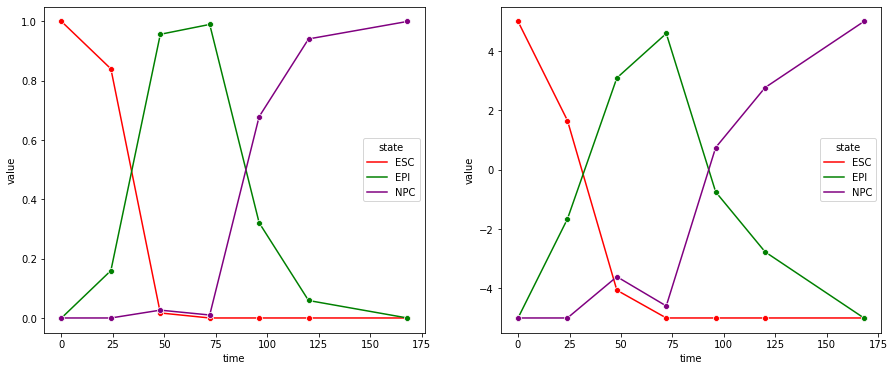

In [8]:
# logit

a = bs_avg['value']
y = logit_transform(a)
bs_logit = bs_avg.copy()
bs_logit['value'] = y

# Compare raw vs logit
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,6)
g = sns.lineplot(x="time", y="value", 
                hue='state', palette=['red', 'green', 'purple'], 
                marker='o', err_style='bars', data=bs_avg[bs_avg['L1']=='R1'], ax=ax[0])



sns.lineplot(x="time", y="value", 
                hue='state', palette=['red', 'green', 'purple'], 
                marker='o', err_style="bars", data=bs_logit[bs_logit['L1']=='R1'], ax=ax[1])

<AxesSubplot:xlabel='time', ylabel='value'>

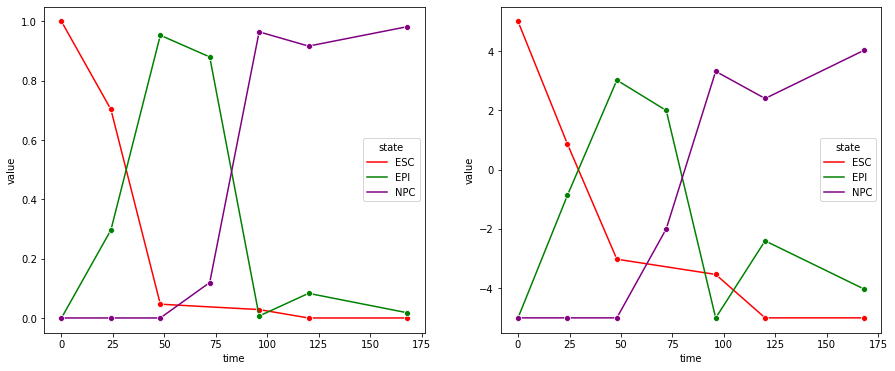

In [9]:
# logit

a = bs_avg['value']
y = logit_transform(a)
bs_logit = bs_avg.copy()
bs_logit['value'] = y

# Compare raw vs logit
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,6)
g = sns.lineplot(x="time", y="value", 
                hue='state', palette=['red', 'green', 'purple'], 
                marker='o', err_style='bars', data=bs_avg[bs_avg['L1']=='E14'], ax=ax[0])



sns.lineplot(x="time", y="value", 
                hue='state', palette=['red', 'green', 'purple'], 
                marker='o', err_style="bars", data=bs_logit[bs_logit['L1']=='E14'], ax=ax[1])

Text(0.5, 1.0, 'Sample averages normalised + logit transformed')

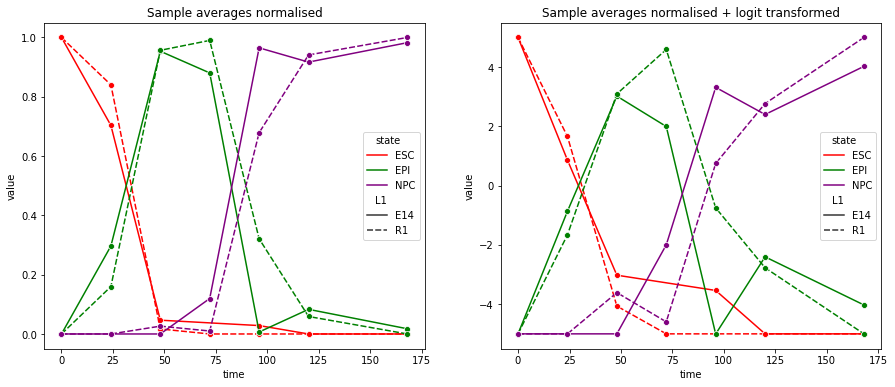

In [10]:
# plot both R1 and E14
a = bs_avg['value']
y = logit_transform(a, t=5)
bs_logit = bs_avg.copy()
bs_logit['value'] = y

# Compare raw vs logit
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,6)
g = sns.lineplot(x="time", y="value", style='L1',
                hue='state', palette=['red', 'green', 'purple'], 
                marker='o', err_style='bars', data=bs_avg, ax=ax[0])
ax[0].set_title('Sample averages normalised')


sns.lineplot(x="time", y="value", style='L1',
                hue='state', palette=['red', 'green', 'purple'], 
                marker='o', err_style="bars", data=bs_logit, ax=ax[1])
ax[1].set_title('Sample averages normalised + logit transformed')

# Run naive simulation for R1 cell line
- The r_0 parameter was determined roughly from experimental plots and their half-lives: $r_0 = \frac{ln(2)}{t_{1/2}}$

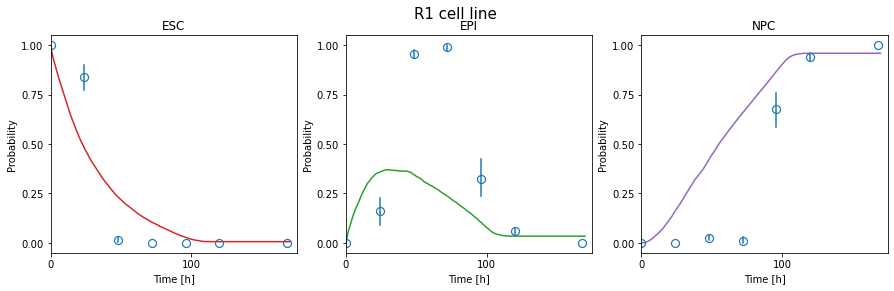

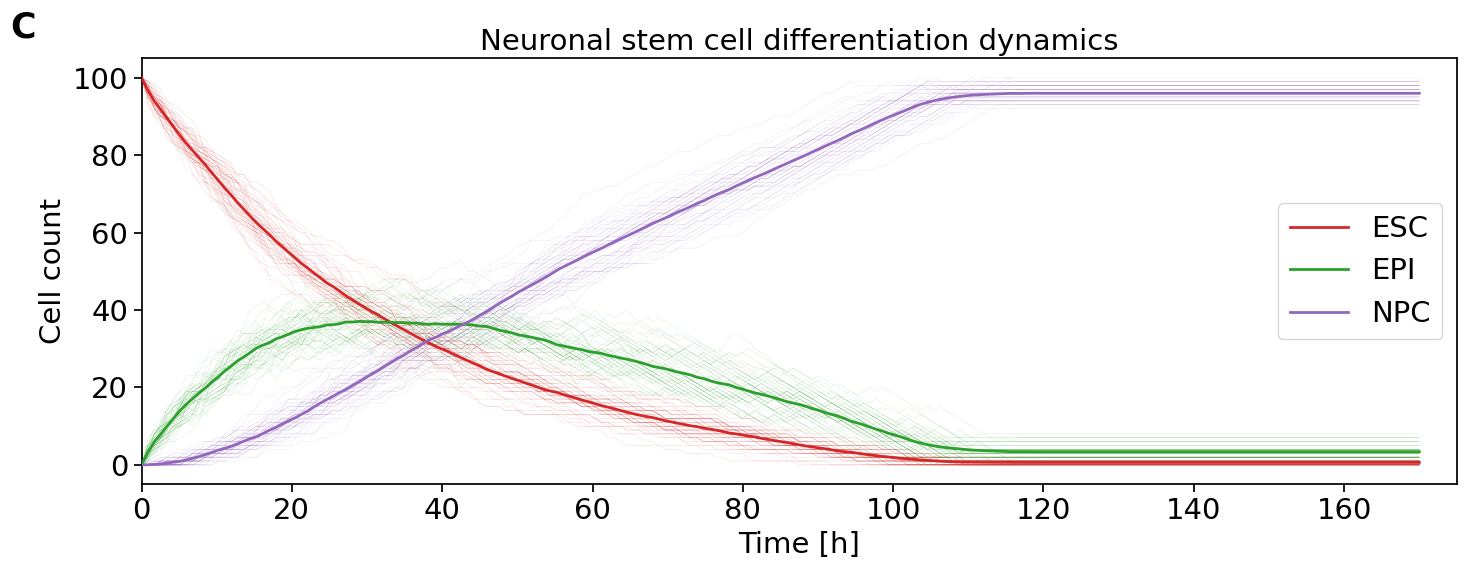

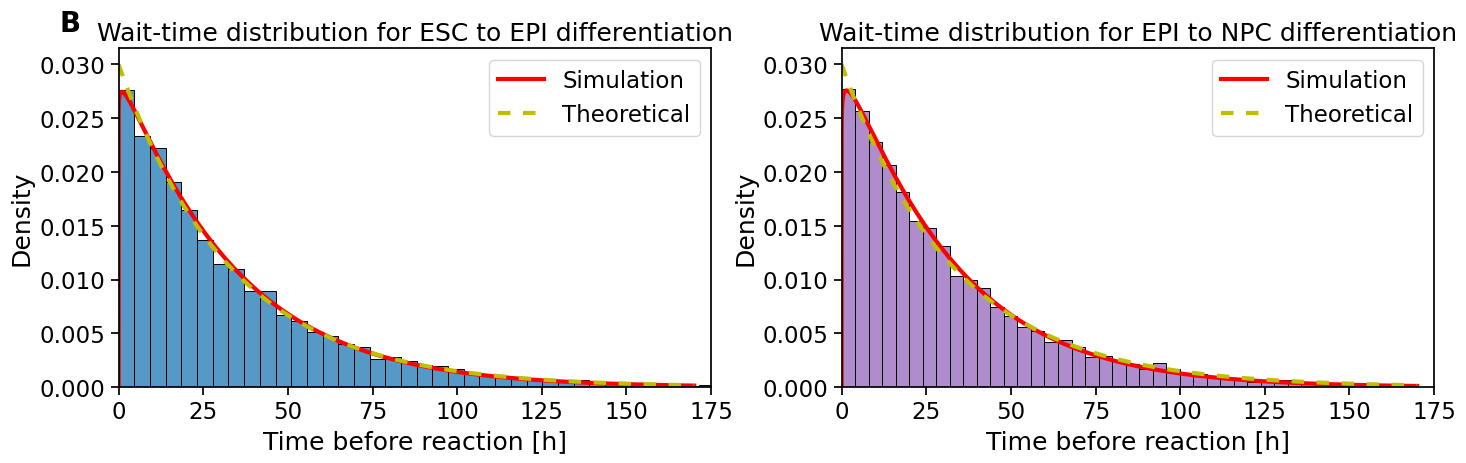

ESC:
   Obtained rate is 0.030 vs 0.030
   Corresponding to 32.8h vs 33.3h
   std is 31.3h
EPI:
   Obtained rate is 0.032 vs 0.030
   Corresponding to 31.4h vs 33.3h
   std is 29.4h
RMSE:
 ESC = 0.13847544862170458
 EPI = 0.07107369562017209
 NPC = 0.0875033728465507
 Average = 0.09901750569614244


In [11]:
# Load experimental data
count_df = load_data('./data')
# L1 norm
count_df[['ESC', 'EPI', 'NPC']] = normalize(count_df[['ESC', 'EPI', 'NPC']], norm='l1')
# Convert to long format
count_long = count_df.melt(id_vars=['Time', 'Source'], value_vars=['ESC', 'EPI', 'NPC'], var_name='Cell type', value_name='Count')
# samples for bootstrapping
bs_raw = pd.read_csv('./data/bootstraps10.csv')

# Define simulation parameters
channels = {
        'esc' : Channel('esc', r0=0.03, alpha=0),
        'epi' : Channel('epi', r0=0.03, alpha=0)
    }
t_end = 170
n_sim = 100
timepoints = 200

# Run simulation
population, channels_out, t2_error = simulate(t_end, n_sim, timepoints, channels, verbose=False)
# Convert simulation np.array to pd.DataFrame, long format
# The function also normalises the simulation using L1 norm
pop_long = arr_to_df(population, t_end, scaler=None, long=True)

# create pop_df wide form for rmse calculation
pop_df = arr_to_df(population, t_end, scaler=None, long=False)

# Combine simulation and experimental dfs
combined_df = pd.concat([pop_long, count_long], axis=0)

# Plot simulation vs experimental
plot_sim_vs_exp(pop_long, bs_raw, cell_line='R1', filepath='./figures/sim_vs_exp.png')

# Plot simulation only
plot_population(population, t_end, filepath='./figures/population.png')

# Plot wait-time distributions
plot_event_dist(channels_out,t_end, filepath='./figures/event_dist.png')

# Calulcate rmse
rmse = calculate_rmse(count_df, pop_df)

# Hyperparameter search for R1 cell line - toy example
Working example on a small scale - 3 iterations. Large scale search done on cluster - 30k iterations.
Requires dlib library

In [12]:
def objective_fn(r0_esc, r0_epi, alpha_esc, alpha_epi):
    """
    Args:
        
        
    Returns:
        rmse (float): Average RMSE for all 3 cell types. Simulation vs experimental data.
    """
    bs_raw = pd.read_csv('./data/bootstraps10.csv')
    bs_avg = calculate_bs_avg(bs_raw)
    # remove poor datapoint: e14 75 esc
    idx = bs_avg[(bs_avg.state=='ESC') & (bs_avg.time==72) & (bs_avg.L1=='E14')].index
    bs_avg = bs_avg.drop(idx)
    # Logit transform
    a = bs_avg['value']
    y = logit_transform(a)
    bs_logit = bs_avg.copy()
    bs_logit['value'] = y
    # convert to wide for rmse calculation
    bs_logit_wide = bs_to_wide(bs_logit, cell_line = 'R1')
    
    # Define params
    channels = {
        'esc' : Channel('esc', r0=r0_esc, alpha=alpha_esc),
        'epi' : Channel('epi', r0=r0_epi, alpha=alpha_epi)
    }
    t_end = 300
    n_sim = 500
    timepoints = 300
    
    print("[INFO] starting simulation...")
    print("\tParams: r0_esc = {}, r0_epi = {}, alpha_esc = {}, alpha_epi = {}".format(r0_esc, r0_epi, alpha_esc, alpha_epi))
    population, channels_out, t2_error = simulate(t_end, n_sim, timepoints, channels, verbose=False)
    pop_df = arr_to_df(population, t_end, scaler=None, long=False)
    # Logit transform simulation output
    a = pop_df[['ESC', 'EPI', 'NPC']].values
    y = logit_transform(a)
    pop_logit = pop_df.copy()
    pop_logit[['ESC', 'EPI', 'NPC']] = y
    # Calculate rmse
    rmse = calculate_rmse(bs_logit_wide, pop_logit, verbose=False)
    print("\tSimulation finished with RMSE: {}".format(rmse))
    return rmse


In [ ]:
# simulation takes 10s to run
# num_function_calls: 6*60 * 1 -> 1 hour

x,y = dlib.find_min_global(objective_fn, 
                           bound1 = [0.0100, 0.0100, 0, 0], 
                           bound2 = [0.0800, 0.0800, 6, 6], 
                           is_integer_variable = [False, False, False, False],
                           num_function_calls = int(10*6*60*0.001))

r0_esc, r0_epi, alpha_esc, alpha_epi = x

print('[INFO] Finished!\n')
print("optimal inputs:\n r0_esc = {}\n r0_epi = {}\n alpha_esc = {}\n alpha_epi = {}".format(r0_esc, r0_epi, alpha_esc, alpha_epi))
print("optimal output:\n RMSE = {}".format(y))

filename = 'maxLIPO_out_'+ str(datetime.now().strftime('%Y_%m_%d_%H_%M_%S')) + '.txt'
with open(filename, "w") as file:
    file.write("optimal inputs:\n r0_esc = {}\n r0_epi = {}\n alpha_esc = {}\n alpha_epi = {}\n".format(r0_esc, r0_epi, alpha_esc, alpha_epi))
    file.write("optimal output:\n RMSE = {}".format(y))

## Run simulation using optimal parameters from toy example

### Try after 3 iterations of maxLIPO

In [ ]:
# samples for bootstrapping
bs_raw = pd.read_csv('./data/bootstraps10.csv')
bs_avg = calculate_bs_avg(bs_raw)

channels = {
        'esc' : Channel('esc', r0=r0_esc, alpha=alpha_esc),
        'epi' : Channel('epi', r0=r0_epi, alpha=alpha_epi)
    }
t_end = 350
n_sim = 500
timepoints = 350

# Run simulation R1
population_r1, channels_out_r1, t2_error = simulate(t_end, n_sim, timepoints, channels, verbose=False)
# Convert simulation np.array to pd.DataFrame, long format
# The function also normalises the simulation using L1 norm
pop_long_r1 = arr_to_df(population_r1, t_end, scaler=None, long=True)
print('Finished simulating R1')

# Plot simulation vs experimental
plot_sim_vs_exp(pop_long_r1, bs_raw, cell_line='R1', filepath='./figures/sim_vs_exp_r1.png')

plot_population(population_r1, t_end, filepath='./figures/population_r1.png')
# Plot wait-time distributions
plot_event_dist(channels_out_r1,t_end, filepath='./figures/event_dist_r1.png')
# RMSE
pop_r1 = arr_to_df(population_r1, t_end, scaler=None, long=False)
bs_r1 = bs_to_wide(bs_avg, cell_line = 'R1')
calculate_rmse(bs_r1, pop_r1)

# Run simulations with params after cluster optimisation

In [17]:
# samples for bootstrapping
bs_raw = pd.read_csv('./data/bootstraps10.csv')
bs_avg = calculate_bs_avg(bs_raw)

# Define simulation parameters R1
r0_esc = 0.02749631566426378
r0_epi = 0.017078828582383382
alpha_esc = 4.5382877840619
alpha_epi = 3.596210263062495



channels = {
        'esc' : Channel('esc', r0=r0_esc, alpha=alpha_esc),
        'epi' : Channel('epi', r0=r0_epi, alpha=alpha_epi)
    }
t_end = 350
n_esc = 500
n_sim = 500
timepoints = 350

# Run simulation R1
population_r1, channels_out_r1, t2_error = simulate(t_end, n_sim, timepoints, channels, n_esc = n_esc, order_approx=1, verbose=False)
# Convert simulation np.array to pd.DataFrame, long format
# The function also normalises the simulation using L1 norm
print('Finished simulating R1')


# Define simulation parameters E14


r0_esc = 0.032171966842843534
r0_epi = 0.016751863648585066
alpha_esc = 3.41100504926811
alpha_epi = 3.613655856845829

channels = {
        'esc' : Channel('esc', r0=r0_esc, alpha=alpha_esc),
        'epi' : Channel('epi', r0=r0_epi, alpha=alpha_epi)
    }
# Run simulation E14
population_e14, channels_out_e14, t2_error = simulate(t_end, n_sim, timepoints, channels, n_esc=n_esc, order_approx=1, verbose=False)
print('Finished simulating E14')


# Plot simulation vs experimental
#plot_sim_vs_exp_both(pop_long_r1, pop_long_e14, bs_raw, filepath='./figures/sim_vs_exp.png')





Finished simulating R1
Finished simulating E14


## Save objects


In [18]:
save_obj(population_r1, './objects/population_r1.pkl')
save_obj(channels_out_r1, './objects/channels_out_r1.pkl')
save_obj(population_e14, './objects/population_e14.pkl')
save_obj(channels_out_e14, './objects/channels_out_e14.pkl')

## Plot from saved data

In [15]:
population_r1 = load_obj('./objects/population_r1.pkl')
channels_out_r1= load_obj( './objects/channels_out_r1.pkl')
population_e14= load_obj( './objects/population_e14.pkl')
channels_out_e14=load_obj( './objects/channels_out_e14.pkl')

R1


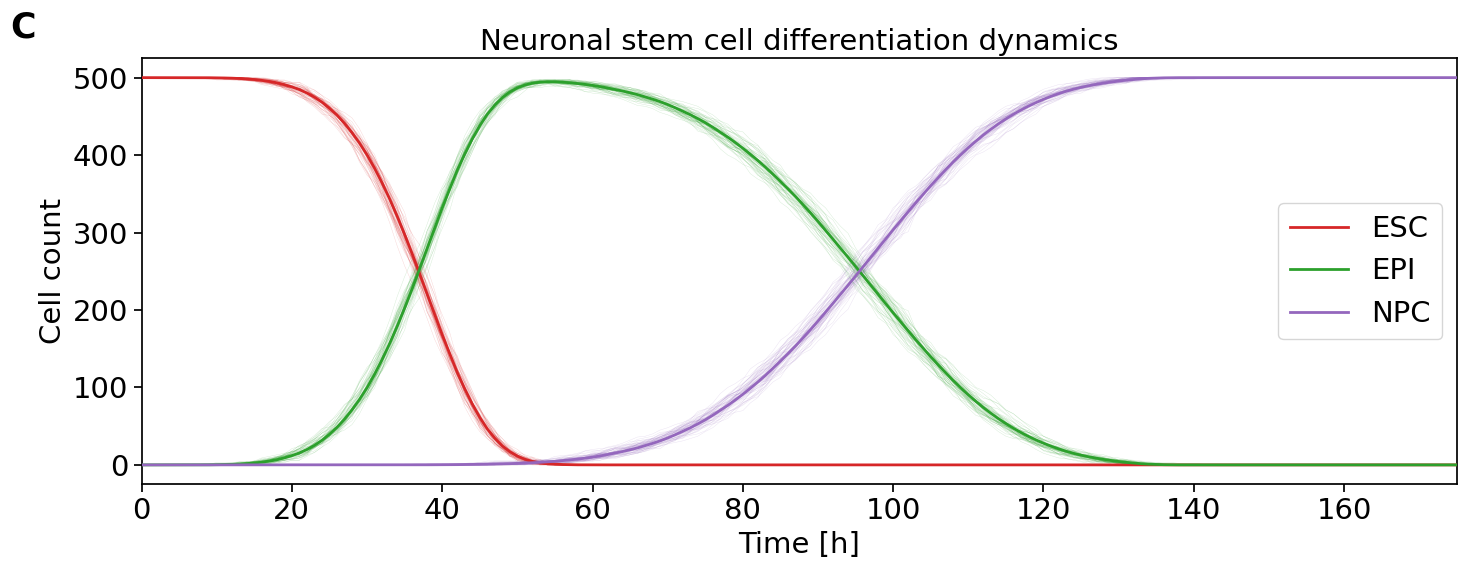

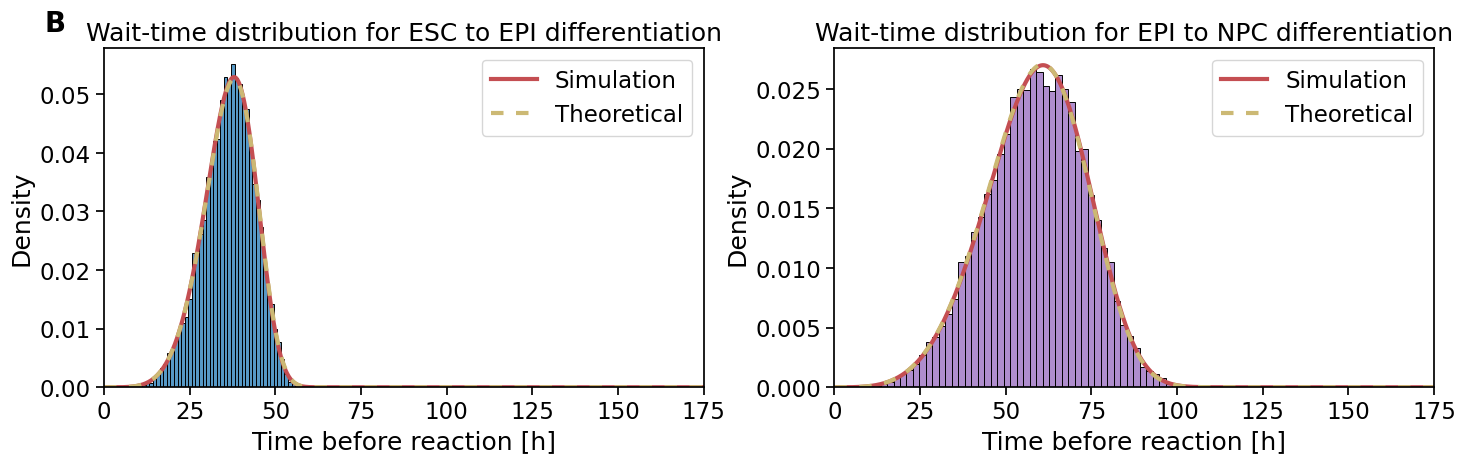

ESC:
   Obtained rate is 0.028 vs 0.027
   Corresponding to 36.3h vs 36.4h
   std is 7.5h
EPI:
   Obtained rate is 0.017 vs 0.017
   Corresponding to 58.7h vs 58.6h
   std is 14.5h
RMSE:
 ESC = 0.03845635679840197
 EPI = 0.07857477511521367
 NPC = 0.07009357696304981
 Average = 0.06237490295888848
E14


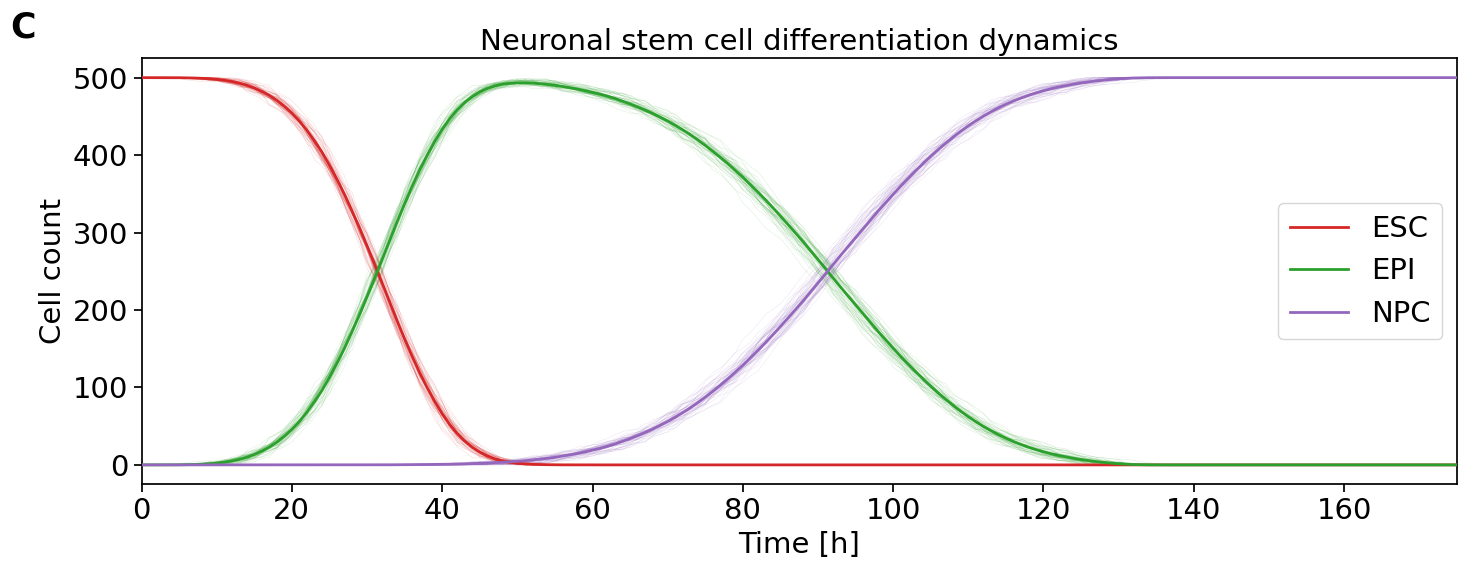

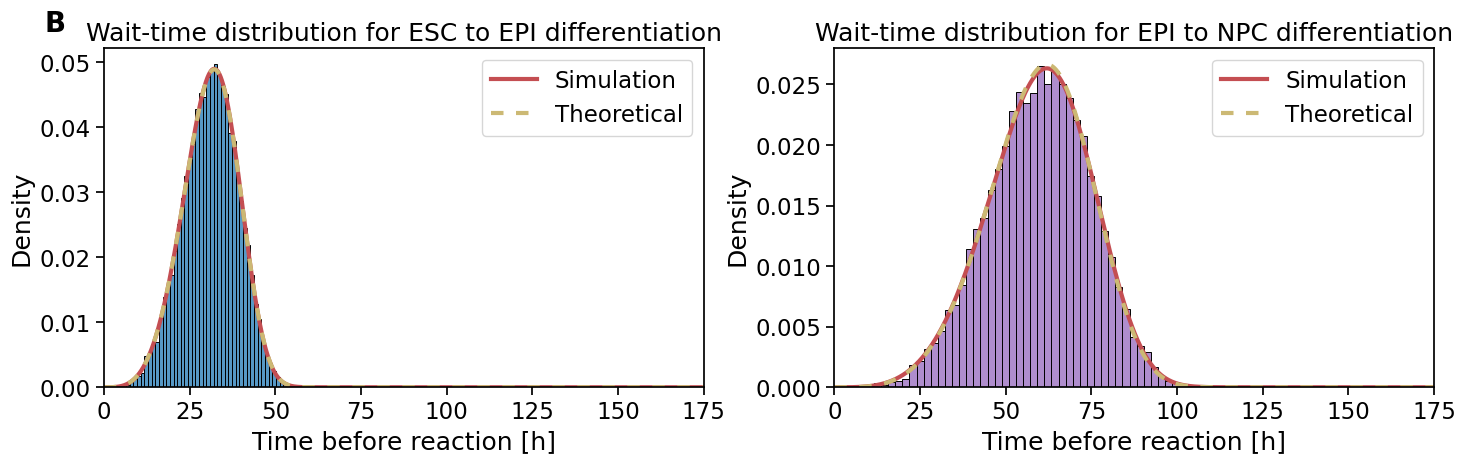

ESC:
   Obtained rate is 0.032 vs 0.032
   Corresponding to 31.1h vs 31.1h
   std is 8.0h
EPI:
   Obtained rate is 0.017 vs 0.017
   Corresponding to 59.8h vs 59.7h
   std is 14.8h
RMSE:
 ESC = 0.04314189575712437
 EPI = 0.15189236008184595
 NPC = 0.1356804300672798
 Average = 0.11023822863541671


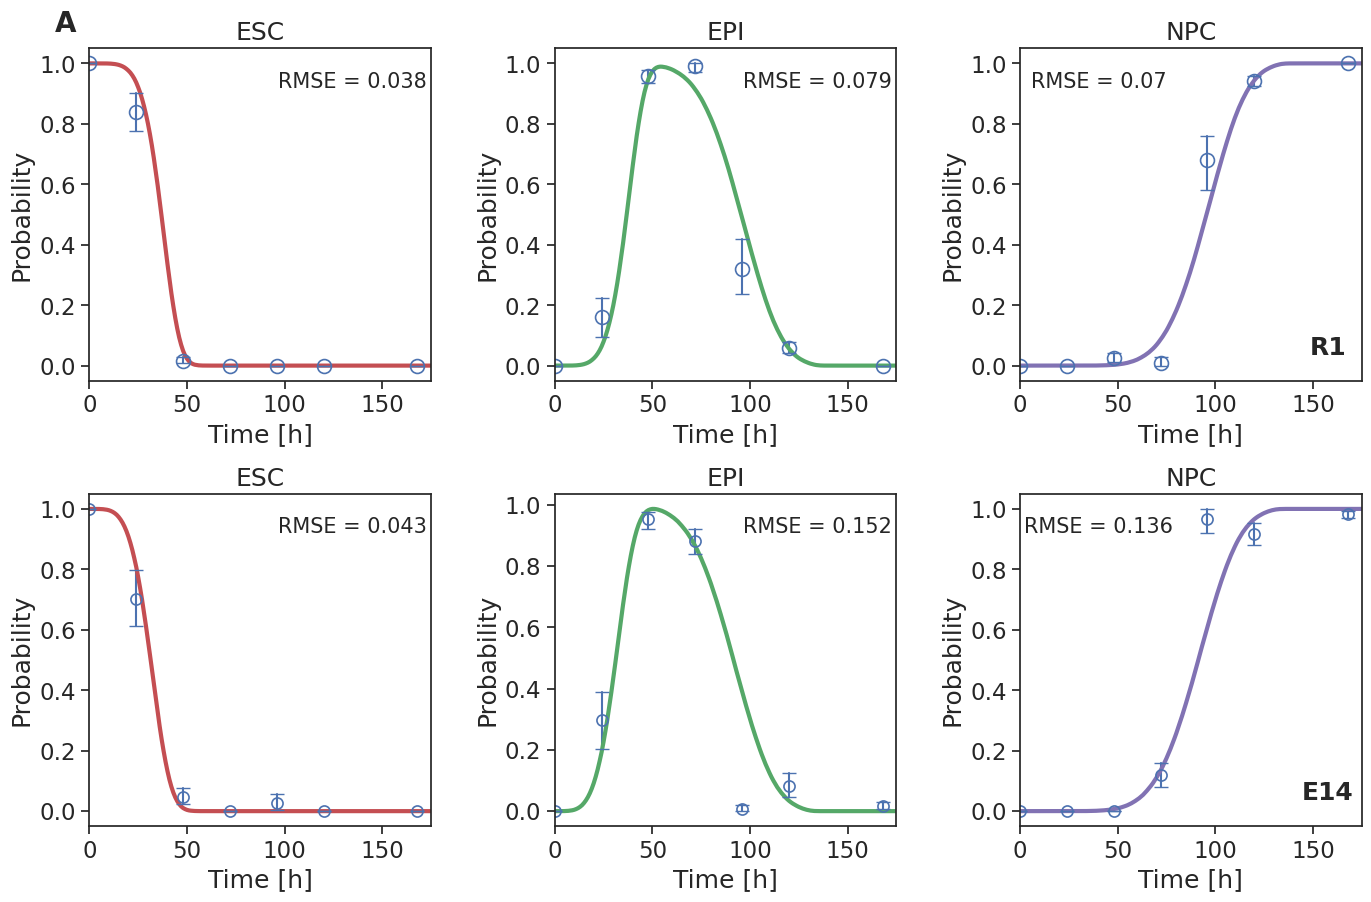

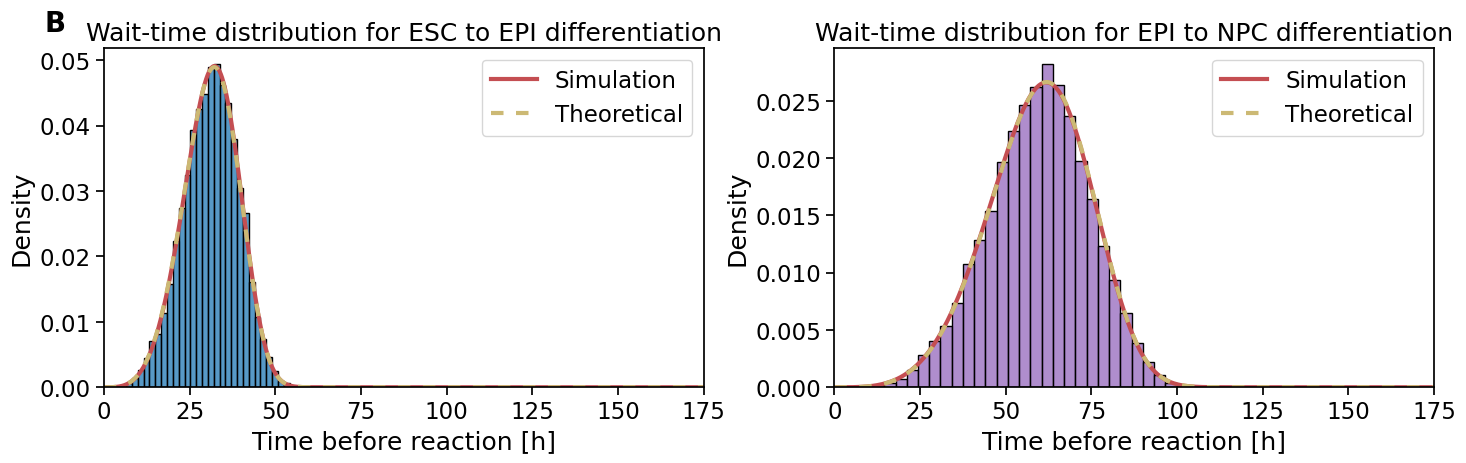

ESC:
   Obtained rate is 0.032 vs 0.032
   Corresponding to 31.1h vs 31.1h
   std is 8.0h
EPI:
   Obtained rate is 0.017 vs 0.017
   Corresponding to 59.6h vs 59.7h
   std is 14.7h


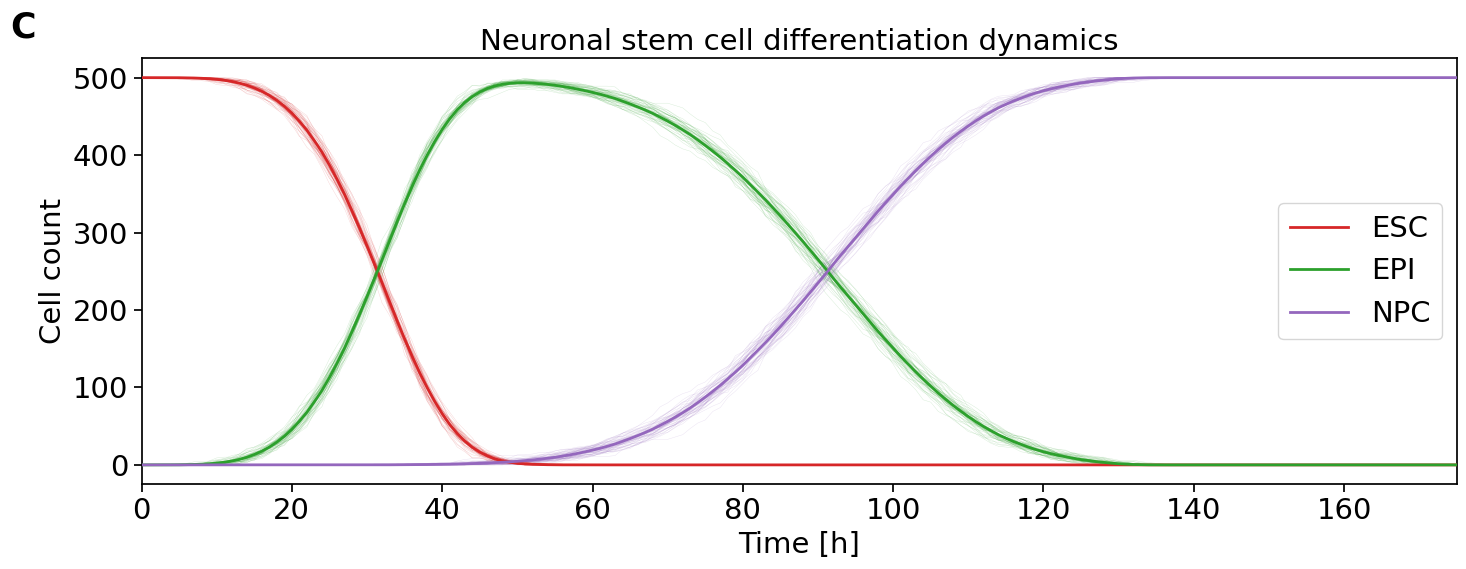

In [19]:
pop_long_r1 = arr_to_df(population_r1, t_end, scaler=None, long=True)
pop_long_e14 = arr_to_df(population_e14, t_end, scaler=None, long=True)



# Plot simulation only
print('R1')
plot_population(population_r1, t_end, filepath='./figures/population_r1.png')
# Plot wait-time distributions
plot_event_dist(channels_out_r1,t_end, filepath='./figures/event_dist_r1.png')
# RMSE
pop_r1 = arr_to_df(population_r1, t_end, scaler=None, long=False)
bs_r1 = bs_to_wide(bs_avg, cell_line = 'R1')
rmse_r1 = calculate_rmse(bs_r1, pop_r1, avg=False)

# Plot simulation only
print('E14')
plot_population(population_e14, t_end, filepath='./figures/population_e14.png')
# Plot wait-time distributions
plot_event_dist(channels_out_e14,t_end, filepath='./figures/event_dist_e14.png')
# RMSE
pop_e14 = arr_to_df(population_e14, t_end, scaler=None, long=False)
bs_e14 = bs_to_wide(bs_avg, cell_line = 'E14')
rmse_e14 = calculate_rmse(bs_e14, pop_e14, avg=False)

rmse_arr = np.vstack([rmse_r1,rmse_e14])
rmse_arr = np.around(rmse_arr, 3)
plot_sim_vs_exp_both(pop_long_r1, pop_long_e14, bs_raw, rmse_arr=rmse_arr, filepath='./figures/sim_vs_exp_rmse.png')

plot_event_dist(channels_out_e14,t_end, bins=30, filepath='./figures/event_dist_e14.png')
plot_population(population_e14, t_end, filepath='./figures/population_e14_annot.png')
